## Imports

In [1]:
# Standard
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Data

In [4]:
file_name = 'gb'
df = pd.read_pickle(f'..\\processed_data\\{file_name}.pki')

In [5]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
0,LP001002,1,0,0,0,0,1.0,2,1,5849.0,0.347222,5848.652778
1,LP001003,1,1,1,0,0,1.0,0,0,6091.0,0.355556,6090.644444
2,LP001005,1,1,0,0,1,1.0,2,1,3000.0,0.183333,2999.816667
3,LP001006,1,1,0,1,0,1.0,2,1,4941.0,0.333333,4940.666667
4,LP001008,1,0,0,0,0,1.0,2,1,6000.0,0.391667,5999.608333


In [6]:
r = random.randint(1, 100)
train, test = train_test_split(df, test_size=.25, random_state=r)

In [7]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis = 1)
y = train['Loan_Status']
print(X.head())
print(y.head())

     Gender  Married Dependents  Education  Self_Employed  Credit_History  \
73        1        1          3          1              0             0.0   
340       1        1          3          1              0             1.0   
180       1        1          1          0              0             0.0   
64        0        0          0          0              0             0.0   
605       1        1          0          1              0             1.0   

     Property_Area  TotalIncome       EMI  BalanceIncome  
73               1       4755.0  0.263889    4754.736111  
340              0       4234.0  0.480556    4233.519444  
180              2      13650.0  0.500000   13649.500000  
64               1       4166.0  0.322222    4165.677778  
605              2       6200.0  0.694444    6199.305556  
73     0
340    0
180    0
64     0
605    0
Name: Loan_Status, dtype: int32


In [8]:
y.value_counts()

Loan_Status
1    302
0    135
Name: count, dtype: int64

## Hyper Parameter training Gradient Boosting

In [30]:
# Find the Best Model
param_grid = {
    'loss': ['log_loss', 'exponential'],
    'n_estimators': [_ for _ in range(100, 501, 100)],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_impurity_decrease': [.1, .25, .3, .35],
    'max_features': ['sqrt', 'log2'],
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=5,scoring='f1_weighted', verbose=5, n_jobs=-1)
grid_search.fit(X, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.1, 0.25, 0.3, 0.35],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1_weighted', verbose=5)

In [31]:
base_model = grid_search.best_estimator_

In [32]:
grid_search.best_params_

{'criterion': 'friedman_mse',
 'loss': 'log_loss',
 'max_features': 'log2',
 'min_impurity_decrease': 0.35,
 'n_estimators': 300}

## Bagging

In [33]:
r = random.randint(1, 101)
model = BaggingClassifier(estimator=base_model, n_estimators=500, bootstrap_features=True, random_state=r, n_jobs=-1)

In [34]:
model.fit(X, y)

BaggingClassifier(bootstrap_features=True,
                  estimator=GradientBoostingClassifier(max_features='log2',
                                                       min_impurity_decrease=0.35,
                                                       n_estimators=300),
                  n_estimators=500, n_jobs=-1, random_state=19)

## Scoring

In [35]:
X_test, y_test = test.drop(columns=['Loan_ID', 'Loan_Status']), test['Loan_Status']

In [36]:
y_pred = model.predict(X_test)

In [37]:
f1_score(y_pred = y_pred, y_true=y_test)

0.8828828828828829

In [38]:
accuracy_score(y_pred = y_pred, y_true=y_test)

0.821917808219178

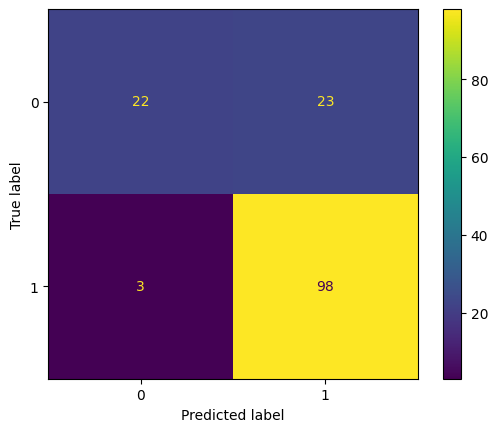

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred = y_pred, y_true=y_test), display_labels=model.classes_)
disp.plot()
plt.show()